In [12]:
# Cell 1: 라이브러리 및 설정
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer # 필요시 기본 결측치 처리 (이제 사용 안 함)
# from sklearn.ensemble import RandomForestRegressor # HB 결측치 처리용 (이제 사용 안 함)
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 스케일러 저장용
import streamlit as st # GUI용 (Cell 12에서만 사용)
import os # GUI용 파일 경로 확인

# 데이터 경로 정의 (파일명 확인 및 수정)
data_path = "/Users/yeojoon/Documents/PyWorkspace_CreativeDesign/TrainSet0417.xlsx" #BakUp0413Materiadata.xlsx"

# 장치 설정 (가능하면 GPU/MPS, 아니면 CPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"사용 장치: {device}")

# 재현성을 위한 랜덤 시드 설정
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
elif device == 'mps':
     pass

print("라이브러리 임포트 및 설정 완료.")

사용 장치: mps
라이브러리 임포트 및 설정 완료.


In [13]:
# Cell 2: 데이터 로딩 및 초기 검사

try:
    # 'Tensile' 시트 로드
    df_tensile = pd.read_excel(data_path, sheet_name='Tensile', header=0)
    print("--- Tensile 시트 ---")
    print(f"형태: {df_tensile.shape}")
    print("\n컬럼:", df_tensile.columns.tolist())
    print("\n처음 5행:\n", df_tensile.head())
    print("\n데이터 타입:\n", df_tensile.dtypes)
    print("\n결측치 요약:\n", df_tensile.isnull().sum())

except FileNotFoundError:
    print(f"오류: {data_path}에서 파일을 찾을 수 없습니다")
except Exception as e:
    print(f"데이터 로딩 중 오류 발생: {e}")

# 필요한 컬럼명 확인 (주석)
# E: 'E'
# YS: 'YS'
# TS: 'TS'
# HB: 'HB'
# HV: 'HV'
# sf: 'sf' (sigma_f')
# b: 'b'
# ef: 'ef' (epsilon_f')
# c: 'c'


# np_col = "n'" # 선택사항
# kp_col = "K' (MPa)" # 선택사항


--- Tensile 시트 ---
형태: (746, 19)

컬럼: ['Material', 'HeatTreatment', 'E', 'YS', 'TS', 'EL', 'RA', 'K', 'n', 'HV', 'HB', 'sy', 'np', 'Kp', 'sf', 'b', 'ef', 'c', '특이사항']

처음 5행:
   Material HeatTreatment      E   YS     TS    EL   RA      K      n   HV  \
0   0.6040           NaN  140.0  420  570.0   NaN  NaN  902.0  0.130  NaN   
1   0.7040           NaN  165.0  323  470.0  17.3  NaN  514.0  0.076  NaN   
2   0.7060           NaN  158.0  382  632.0     7  NaN  507.0  0.043  NaN   
3   0.7060           NaN  175.0  480  738.0   4.4  NaN    NaN    NaN  NaN   
4   0.8155           NaN  155.0  389  600.0     5  NaN  582.0  0.073  NaN   

    HB  sy     np    Kp   sf      b      ef      c                    특이사항  
0  NaN NaN  0.153  1012  646 -0.078  0.0353 -0.451                     NaN  
1  NaN NaN  0.065   677  851 -0.075  9.7123 -1.016                     NaN  
2  NaN NaN  0.076   750  720 -0.058  0.7236 -0.782  C 3.52 Si 2.69 Mn 0.53  
3  NaN NaN  0.103   936  805 -0.067  0.2314 -0.652   

In [14]:
# Cell 3: 컬럼 이름 변경 및 타입 변환

# --- 컬럼 이름 매핑 정의 (실제 파일 컬럼명 기준) ---
column_mapping = {
    'E': 'E_GPa',
    'YS': 'YS_MPa',
    'TS': 'TS_MPa',
    'HB': 'HB',
    'HV': 'HV',
    "sf": 'spf_MPa',
    'b': 'b',
    "ef": 'epf',
    'c': 'c',
    # 사용할 경우 선택적 컬럼 추가
    # "n'": 'np',
    # "K' (MPa)": 'Kp_MPa',
    # 'Material Name', 'RA (%)' 등과 같은 다른 관련 컬럼 추가
    #'RA': 'RA_percent' # RA가 존재하고 필요한 경우 예시
}

# 사용할 컬럼만 선택 및 이름 변경
required_cols = list(column_mapping.keys())
available_cols = [col for col in required_cols if col in df_tensile.columns]
missing_cols = [col for col in required_cols if col not in available_cols]

print(f"\n사용 가능한 컬럼: {available_cols}")
if missing_cols:
    print(f"경고: 다음 컬럼이 데이터에 없습니다: {missing_cols}. 해당 컬럼 없이 진행합니다.")
    # 필수 컬럼 누락 시 에러 처리 또는 중지 로직 추가 가능

# 사용 가능한 컬럼만으로 매핑 재생성
column_mapping_available = {k: v for k, v in column_mapping.items() if k in available_cols}

df = df_tensile[available_cols].copy()
df.rename(columns=column_mapping_available, inplace=True)

hv_col_exists = 'HV' in df.columns

# 숫자형 변환 (오류는 NaN)
numeric_cols_base = ['E_GPa', 'YS_MPa', 'TS_MPa', 'HB', 'spf_MPa', 'b', 'epf', 'c']
numeric_cols = [col for col in numeric_cols_base if col in df.columns] # 존재하는 컬럼만 대상으로 함
if hv_col_exists:
    numeric_cols.append('HV')

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n이름 변경 및 숫자 변환 후 DataFrame:")
print(df.head())
print("\n데이터 타입:\n", df.dtypes)
print("\n강제 변환 후 결측치 요약:\n", df.isnull().sum())

# E 단위 변환 (GPa -> MPa)
if 'E_GPa' in df.columns:
    df['E_MPa'] = df['E_GPa'] * 1000
    df.drop(columns=['E_GPa'], inplace=True)
    print("\nE를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).")
    # Ensure E_MPa is in numeric_cols if E_GPa was
    if 'E_GPa' in numeric_cols:
        numeric_cols.remove('E_GPa')
        if 'E_MPa' not in numeric_cols:
             numeric_cols.append('E_MPa')


# 최종 특성 및 타겟 컬럼 이름 정의 (HB는 Cell 4에서 처리 후 추가)
feature_cols_base = ['E_MPa', 'YS_MPa', 'TS_MPa']
feature_cols = [col for col in feature_cols_base if col in df.columns] # 존재하는 특성만 사용
target_cols_base = ['spf_MPa', 'b', 'epf', 'c']
target_cols = [col for col in target_cols_base if col in df.columns] # 존재하는 타겟만 사용

# 타겟 변수 누락 행 제거
if not target_cols:
     print("오류: 타겟 변수가 하나도 없습니다. 학습을 진행할 수 없습니다.")
else:
    initial_rows = len(df)
    df.dropna(subset=target_cols, inplace=True)
    print(f"\n타겟 값({target_cols})이 누락된 {initial_rows - len(df)}개 행을 삭제했습니다.")
    print(f"남은 행: {len(df)}")


사용 가능한 컬럼: ['E', 'YS', 'TS', 'HB', 'HV', 'sf', 'b', 'ef', 'c']

이름 변경 및 숫자 변환 후 DataFrame:
   E_GPa  YS_MPa  TS_MPa  HB  HV  spf_MPa      b     epf      c
0  140.0   420.0   570.0 NaN NaN    646.0 -0.078  0.0353 -0.451
1  165.0   323.0   470.0 NaN NaN    851.0 -0.075  9.7123 -1.016
2  158.0   382.0   632.0 NaN NaN    720.0 -0.058  0.7236 -0.782
3  175.0   480.0   738.0 NaN NaN    805.0 -0.067  0.2314 -0.652
4  155.0   389.0   600.0 NaN NaN    712.0 -0.073  0.1460 -0.573

데이터 타입:
 E_GPa      float64
YS_MPa     float64
TS_MPa     float64
HB         float64
HV         float64
spf_MPa    float64
b          float64
epf        float64
c          float64
dtype: object

강제 변환 후 결측치 요약:
 E_GPa       13
YS_MPa      52
TS_MPa      40
HB         288
HV         681
spf_MPa     42
b           35
epf         43
c           37
dtype: int64

E를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).

타겟 값(['spf_MPa', 'b', 'epf', 'c'])이 누락된 44개 행을 삭제했습니다.
남은 행: 702


In [15]:
# Cell 4: HB/HV 처리 (수정됨 - ML/Median 대체 제거, HV 변환 우선)

hb_col_name = 'HB' # 원본 HB 컬럼명 (매핑 후 이름)
hv_col_name = 'HV' # 원본 HV 컬럼명 (매핑 후 이름)
hb_processed_col = 'HB_processed' # 새로 생성할 처리된 HB 컬럼

if hb_col_name not in df.columns:
    print(f"경고: HB 컬럼('{hb_col_name}')이 없습니다. HB 특성을 사용할 수 없습니다.")
    # HB 컬럼이 아예 없으면 hb_processed 생성 불가 -> 이후 로직에서 HB 사용 제외 필요
    hb_available = False
else:
    hb_available = True
    df[hb_processed_col] = df[hb_col_name].copy() # 기본값: 원본 HB 사용

    # HB가 NaN 이고 HV가 있는 경우, HV -> HB 변환
    if hv_col_exists:
        conversion_mask = df[hb_processed_col].isnull() & df[hv_col_name].notnull()
        # 예시 변환 (필요시 수정)
        df.loc[conversion_mask, hb_processed_col] = 0.95 * df.loc[conversion_mask, hv_col_name]
        print(f"Imputed {conversion_mask.sum()} missing HB values using HV conversion.")
    else:
        print("HV column not found. Skipping HV->HB conversion.")

    # HB_processed 컬럼을 feature_cols 에 추가
    feature_cols.append(hb_processed_col)
    print(f"\n'{hb_processed_col}' 컬럼을 특성에 추가했습니다.")

    # HB_processed 가 여전히 NaN 인 행은 HB/HV 모두 없는 경우 -> 분석에서 제외
    initial_rows_before_hb_drop = len(df)
    df.dropna(subset=[hb_processed_col], inplace=True)
    dropped_for_hb = initial_rows_before_hb_drop - len(df)
    if dropped_for_hb > 0:
        print(f"\nDropped {dropped_for_hb} rows where both HB and HV were missing or invalid.")


# 최종 특성 컬럼에서 결측치가 있는 행 제거 (E, YS, TS 등 포함)
initial_rows_before_feature_drop = len(df)
df.dropna(subset=feature_cols, inplace=True)
dropped_for_features = initial_rows_before_feature_drop - len(df)
if dropped_for_features > 0:
     print(f"Dropped {dropped_for_features} rows with missing values in features: {feature_cols}.")

print(f"\nFinal Feature Columns: {feature_cols}")
print(f"Target Columns: {target_cols}")
print("\nDataFrame after HB/HV processing and final NA drop:")
print(df[feature_cols + target_cols].head())
print("\nMissing values check for final features and targets:")
print(df[feature_cols + target_cols].isnull().sum())
print(f"Final number of samples for training/testing: {len(df)}")

Imputed 64 missing HB values using HV conversion.

'HB_processed' 컬럼을 특성에 추가했습니다.

Dropped 189 rows where both HB and HV were missing or invalid.
Dropped 25 rows with missing values in features: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed'].

Final Feature Columns: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed']
Target Columns: ['spf_MPa', 'b', 'epf', 'c']

DataFrame after HB/HV processing and final NA drop:
       E_MPa  YS_MPa  TS_MPa  HB_processed  spf_MPa      b     epf      c
28  206000.0   540.0   790.0       2280.00    987.0 -0.083  0.9672 -0.712
31  181000.0   149.0   411.0        168.15    575.0 -0.097  0.1141 -0.371
32  177000.0   147.0   413.0        190.00    517.0 -0.082  0.1273 -0.379
33  158000.0   130.0   389.0        208.05    479.0 -0.068  0.0817 -0.370
34  204000.0   222.0   569.0        227.05   1655.0 -0.134  0.0667 -0.322

Missing values check for final features and targets:
E_MPa           0
YS_MPa          0
TS_MPa          0
HB_processed    0
spf_MPa         0
b 


--- Exploratory Data Analysis ---

Descriptive Statistics (Features and Targets):
               E_MPa       YS_MPa      TS_MPa  HB_processed      spf_MPa  \
count     488.000000   488.000000   488.00000    488.000000   488.000000   
mean   204192.520492   700.803279   957.47377    276.373258  1400.856557   
std     10077.884096   461.201228   475.54805    204.041588   602.336007   
min    158000.000000   130.000000   318.00000     80.000000   391.000000   
25%    200000.000000   350.000000   616.55000    178.500000  1004.750000   
50%    206000.000000   572.000000   835.00000    243.000000  1228.000000   
75%    210000.000000   890.500000  1125.75000    323.000000  1731.000000   
max    249000.000000  2536.000000  2912.00000   2440.000000  4569.000000   

                b         epf           c  
count  488.000000  488.000000  488.000000  
mean    -0.094678    0.752123   -0.593907  
std      0.030713    1.176414    0.138716  
min     -0.253000    0.003000   -1.050000  
25%     -0.1

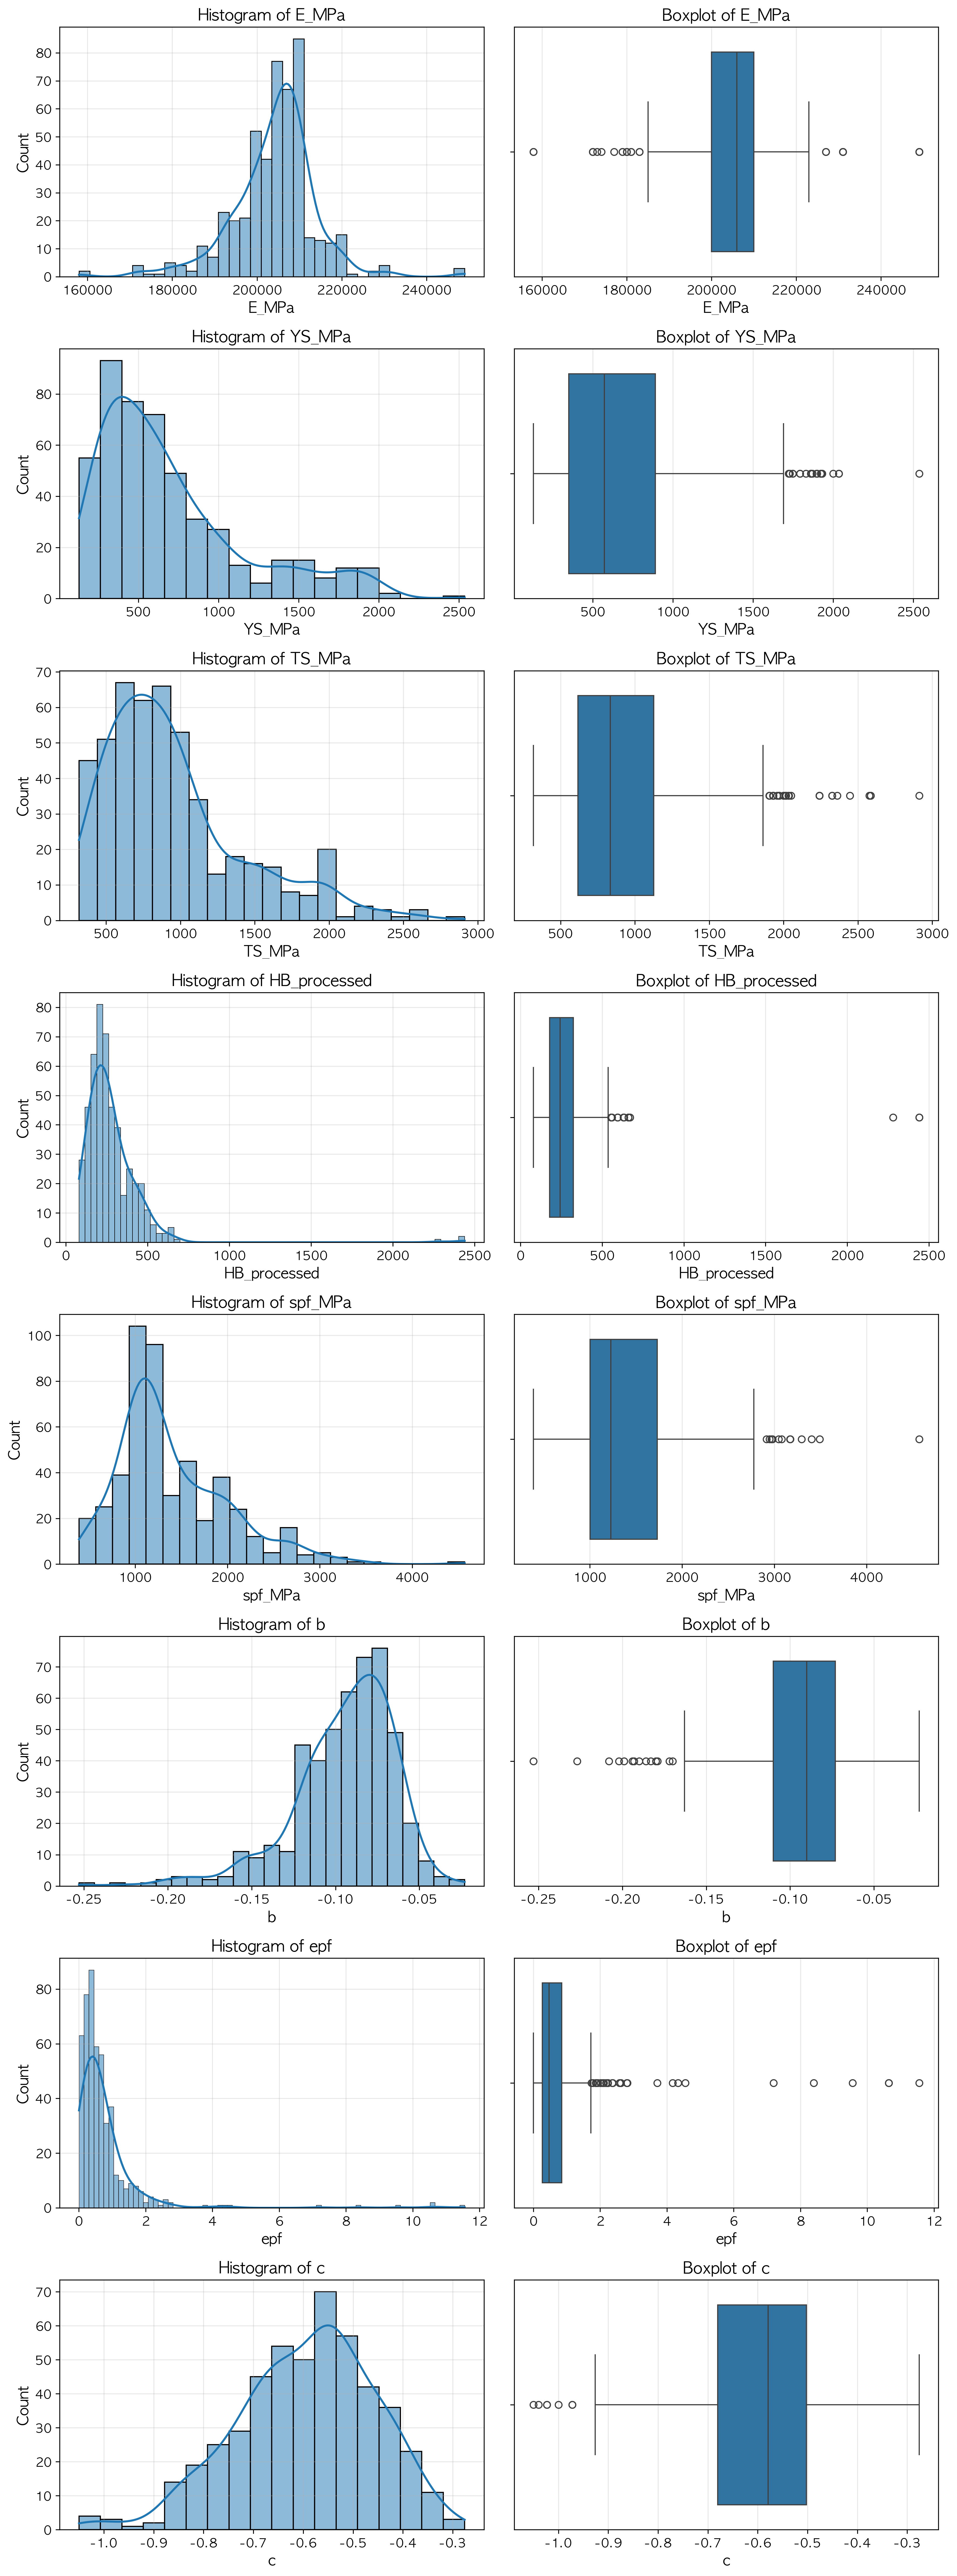


Calculating and Plotting Correlation Matrix...


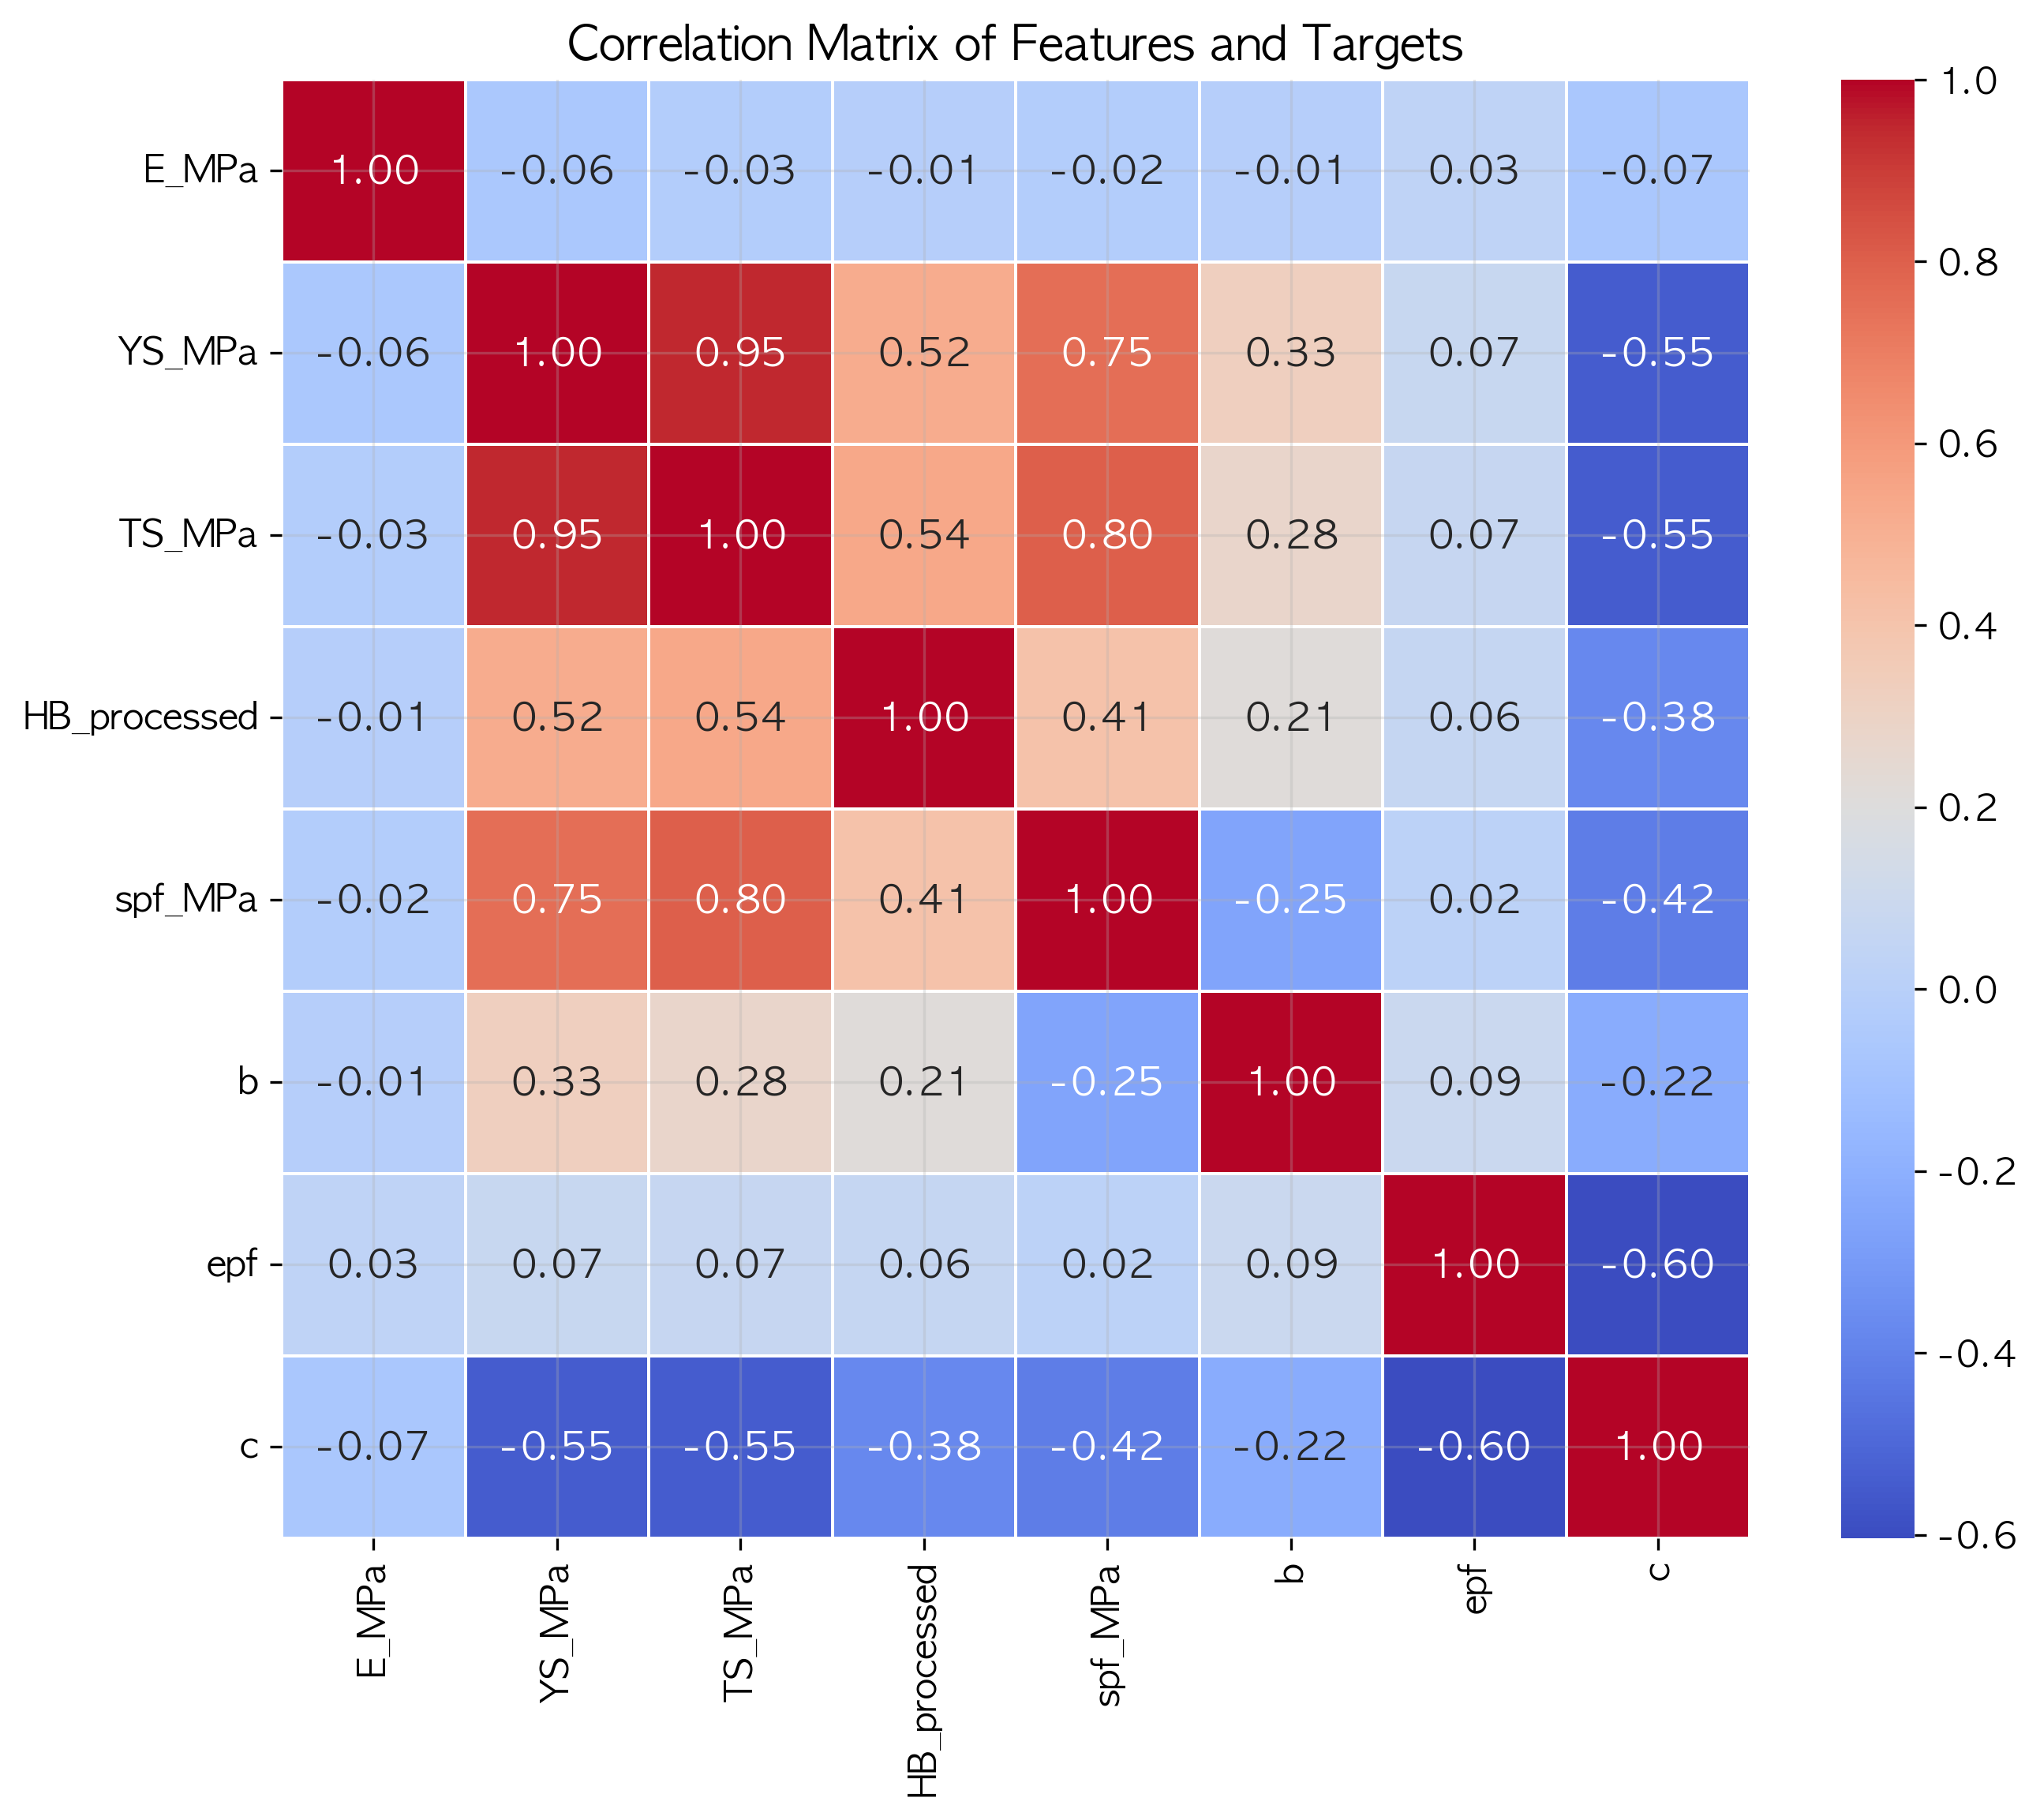


Analysis of target parameters:
Range of 'b': -0.253 -0.023
Range of 'c': -1.05 -0.276
Percentage of non-negative 'b': 0.00%
Percentage of non-negative 'c': 0.00%
Percentage where spf_MPa <= TS_MPa: 3.07%


In [16]:

# Cell 5: 탐색적 데이터 분석 (EDA) - 큰 변경 없음, HB_imputed_flag_col 관련 부분 제거

print("\n--- Exploratory Data Analysis ---")

if len(df) > 0: # 데이터가 남아있는 경우에만 EDA 수행
    # 1. Descriptive Statistics
    print("\nDescriptive Statistics (Features and Targets):")
    print(df[feature_cols + target_cols].describe())

    # 2. Distributions
    print("\nPlotting Distributions...")
    n_features = len(feature_cols)
    n_targets = len(target_cols)
    # figure 크기 동적 조절
    fig_height = max(4 * (n_features + n_targets), 12)
    fig, axes = plt.subplots(n_features + n_targets, 2, figsize=(12, fig_height))

    if n_features + n_targets == 1: # 축 객체가 1차원 배열인 경우 처리
        axes = np.array([axes])

    for i, col in enumerate(feature_cols + target_cols):
        if col in df.columns: # 컬럼 존재 확인
             sns.histplot(df[col], kde=True, ax=axes[i, 0])
             axes[i, 0].set_title(f'Histogram of {col}')
             sns.boxplot(x=df[col], ax=axes[i, 1])
             axes[i, 1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

    # 3. Correlation Matrix
    print("\nCalculating and Plotting Correlation Matrix...")
    # 상관관계 계산 전, 수치형 데이터만 있는지 확인
    numeric_df_for_corr = df[feature_cols + target_cols].select_dtypes(include=np.number)
    if not numeric_df_for_corr.empty:
        correlation_matrix = numeric_df_for_corr.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Features and Targets')
        plt.show()
    else:
        print("No numeric columns found for correlation analysis.")


    # 4. Pair Plots (optional)
    # ...

    # 5. Analysis of Target Parameters (Physical Plausibility)
    print("\nAnalysis of target parameters:")
    if 'b' in df.columns: print("Range of 'b':", df['b'].min(), df['b'].max())
    if 'c' in df.columns: print("Range of 'c':", df['c'].min(), df['c'].max())
    if 'b' in df.columns: print(f"Percentage of non-negative 'b': { (df['b'] >= 0).mean() * 100:.2f}%")
    if 'c' in df.columns: print(f"Percentage of non-negative 'c': { (df['c'] >= 0).mean() * 100:.2f}%")
    if 'spf_MPa' in df.columns and 'TS_MPa' in df.columns:
         print(f"Percentage where spf_MPa <= TS_MPa: { (df['spf_MPa'] <= df['TS_MPa']).mean() * 100:.2f}%")

    # HB imputation status 비교 제거 (HB_imputed_flag_col 없음)

else:
    print("\nNo data available for EDA after preprocessing.")


In [17]:
# Cell 6: 데이터 준비 (PyTorch용) - df 사용 확인

print("\n--- Preparing Data for PyTorch (Tensile Model) ---")

if len(df) > 0:
    # Select final features (X) and targets (y) for tensile model
    X = df[feature_cols].values
    y = df[target_cols].values
    # E_MPa 컬럼이 있는지 확인 후 추출
    if 'E_MPa' in df.columns:
        E_for_loss = df['E_MPa'].values
        print(f"E for loss shape: {E_for_loss.shape}")
    else:
        print("Warning: E_MPa column not found. Cannot extract E for physics loss calculation.")
        E_for_loss = np.zeros(len(df)) # 임시값 또는 다른 처리 필요

    print(f"Features shape (X): {X.shape}")
    print(f"Targets shape (y): {y.shape}")

    # 1. Train-Validation-Test Split
    X_train_val, X_test, y_train_val, y_test, E_train_val, E_test = train_test_split(
        X, y, E_for_loss, test_size=0.15, random_state=seed)
    X_train, X_val, y_train, y_val, E_train, E_val = train_test_split(
        X_train_val, y_train_val, E_train_val, test_size=0.1765, random_state=seed) # 0.1765 * 0.85 ≈ 0.15

    print(f"Train set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # 2. Scaling
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)
    y_test_scaled = scaler_y.transform(y_test)

    joblib.dump(scaler_X, 'scaler_X.pkl')
    joblib.dump(scaler_y, 'scaler_y.pkl')
    print("Features and targets scaled. Scalers saved.")

    # 3. Create PyTorch Datasets and DataLoaders
    batch_size = 16

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    E_train_tensor = torch.tensor(E_train, dtype=torch.float32).unsqueeze(1)

    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
    E_val_tensor = torch.tensor(E_val, dtype=torch.float32).unsqueeze(1)

    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
    E_test_tensor = torch.tensor(E_test, dtype=torch.float32).unsqueeze(1)
    y_test_orig_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor, E_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor, E_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor, E_test_tensor, y_test_orig_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("PyTorch Datasets and DataLoaders created for tensile model.")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")

else:
    print("\\nNo data available for PyTorch preparation.")


--- Preparing Data for PyTorch (Tensile Model) ---
E for loss shape: (488,)
Features shape (X): (488, 4)
Targets shape (y): (488, 4)
Train set size: 340
Validation set size: 74
Test set size: 74
Features and targets scaled. Scalers saved.
PyTorch Datasets and DataLoaders created for tensile model.
Number of training batches: 22
Number of validation batches: 5
Number of test batches: 5


In [18]:
# Cell 7: PINN 모델 정의

if len(df) > 0:
    class FatiguePINN(nn.Module):
        def __init__(self, input_dim, output_dim, hidden_dims=[128, 256, 128]):
            super().__init__()
            self.input_dim = input_dim
            self.output_dim = output_dim

            layers = []
            last_dim = input_dim
            for hidden_dim in hidden_dims:
                layers.append(nn.Linear(last_dim, hidden_dim))
                layers.append(nn.ReLU())
                last_dim = hidden_dim
            layers.append(nn.Linear(last_dim, output_dim))
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # 모델 인스턴스화
    input_dim = X_train_scaled.shape[1] if 'X_train_scaled' in locals() else 4 # 예비 차원
    output_dim = y_train_scaled.shape[1] if 'y_train_scaled' in locals() else 4 # 예비 차원
    hidden_dims = [128, 256, 128]
    model = FatiguePINN(input_dim, output_dim, hidden_dims).to(device)

    print("PINN Model Definition (FatiguePINN):")
    print(model)

    # 더미 테스트
    try:
        dummy_input = torch.randn(batch_size, input_dim).to(device)
        dummy_output = model(dummy_input)
        print(f"\\nDummy input shape: {dummy_input.shape}")
        print(f"Dummy output shape: {dummy_output.shape}")
    except Exception as e:
        print(f"\\nCould not perform dummy test: {e}")
else:
    print("\\nSkipping model definition as no data is available.")

PINN Model Definition (FatiguePINN):
FatiguePINN(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)
\nDummy input shape: torch.Size([16, 4])
Dummy output shape: torch.Size([16, 4])


In [19]:
# Cell 8: 손실 함수 정의 (PINN) - 변경 없음

if len(df) > 0:
    def pinn_loss_function(model_outputs_scaled, targets_scaled, E_unscaled, scaler_y, lambda_physics=0.1, num_physics_points=20, Nf_min=1e1, Nf_max=1e7, device='cpu'):
        """
        Calculates the combined Data and Physics loss for the Fatigue PINN.
        (Function definition remains the same as provided previously)
        """
        # 1. Data Loss (MSE on scaled parameters)
        data_loss_fn = nn.MSELoss()
        data_loss = data_loss_fn(model_outputs_scaled, targets_scaled)

        # 2. Physics Loss (Coffin-Manson)
        physics_loss = torch.tensor(0.0, device=device) # 기본값 초기화
        try:
            # Inverse transform the *predicted* parameters
            model_outputs_unscaled_np = scaler_y.inverse_transform(model_outputs_scaled.detach().cpu().numpy())
            model_outputs_unscaled = torch.tensor(model_outputs_unscaled_np, dtype=torch.float32).to(device)

            spf_pred = model_outputs_unscaled[:, 0].unsqueeze(1)
            b_pred = model_outputs_unscaled[:, 1].unsqueeze(1)
            epf_pred = model_outputs_unscaled[:, 2].unsqueeze(1)
            c_pred = model_outputs_unscaled[:, 3].unsqueeze(1)

            reversals = torch.logspace(torch.log10(torch.tensor(Nf_min)), torch.log10(torch.tensor(Nf_max)), num_physics_points).unsqueeze(0).to(device)

            # Avoid division by zero or invalid E
            E_unscaled_safe = torch.where(E_unscaled <= 0, torch.tensor(1e-6, device=device), E_unscaled)

            epsilon_a_pred = (spf_pred / E_unscaled_safe) * (reversals ** b_pred) + epf_pred * (reversals ** c_pred)

            # Inverse transform the *target* parameters
            targets_unscaled_np = scaler_y.inverse_transform(targets_scaled.detach().cpu().numpy())
            targets_unscaled = torch.tensor(targets_unscaled_np, dtype=torch.float32).to(device)
            spf_true = targets_unscaled[:, 0].unsqueeze(1)
            b_true = targets_unscaled[:, 1].unsqueeze(1)
            epf_true = targets_unscaled[:, 2].unsqueeze(1)
            c_true = targets_unscaled[:, 3].unsqueeze(1)
            epsilon_a_true = (spf_true / E_unscaled_safe) * (reversals ** b_true) + epf_true * (reversals ** c_true)

            physics_loss = torch.mean((epsilon_a_pred - epsilon_a_true)**2)

            # Handle potential NaN in physics loss (e.g., from large exponents)
            if torch.isnan(physics_loss):
                 physics_loss = torch.tensor(0.0, device=device)

        except Exception as e:
            print(f"Warning: Error calculating physics loss: {e}. Setting physics loss to 0 for this batch.")
            physics_loss = torch.tensor(0.0, device=device)


        # 3. Total Loss
        total_loss = data_loss + lambda_physics * physics_loss

        return total_loss, data_loss, physics_loss

    # --- Test the loss function ---
    try:
        sample_X, sample_y_scaled, sample_E = next(iter(train_loader))
        sample_X, sample_y_scaled, sample_E = sample_X.to(device), sample_y_scaled.to(device), sample_E.to(device)

        model.eval()
        with torch.no_grad():
             sample_output_scaled = model(sample_X)

        lambda_physics_value = 0.01 # 테스트 및 튜닝용 람다 값
        total_loss, data_loss, physics_loss = pinn_loss_function(
            sample_output_scaled, sample_y_scaled, sample_E, scaler_y, lambda_physics=lambda_physics_value, device=device
        )

        print(f"\nTesting Loss Function:")
        print(f"  Sample Output (scaled) shape: {sample_output_scaled.shape}")
        print(f"  Sample Target (scaled) shape: {sample_y_scaled.shape}")
        print(f"  Sample E (unscaled) shape: {sample_E.shape}")
        print(f"  Calculated Total Loss: {total_loss.item():.4f}")
        print(f"  Calculated Data Loss: {data_loss.item():.4f}")
        print(f"  Calculated Physics Loss: {physics_loss.item():.4f}")

    except Exception as e:
        print(f"\nCould not test loss function, likely due to data loader issue: {e}")
        lambda_physics_value = 0.01 # 기본값 설정

else:
    print("\\nSkipping loss function definition and testing.")
    lambda_physics_value = 0.01 # 기본값


Testing Loss Function:
  Sample Output (scaled) shape: torch.Size([16, 4])
  Sample Target (scaled) shape: torch.Size([16, 4])
  Sample E (unscaled) shape: torch.Size([16, 1])
  Calculated Total Loss: 0.9691
  Calculated Data Loss: 0.9691
  Calculated Physics Loss: 0.0005



--- Starting Training ---
Epochs: 200, LR: 0.001, Lambda_Physics: 0.01, Patience: 20
Epoch [1/200], Train Loss: 0.8073 (Data: 0.8072, Phys: 0.0013), Val Loss: 0.6668 (Data: 0.6668, Phys: 0.0013)
  Validation loss improved. Saved best model.
Epoch [2/200], Train Loss: 0.6994 (Data: 0.6994, Phys: 0.0015), Val Loss: 0.6481 (Data: 0.6481, Phys: 0.0011)
  Validation loss improved. Saved best model.
Epoch [3/200], Train Loss: 0.6673 (Data: 0.6672, Phys: 0.0012), Val Loss: 0.6075 (Data: 0.6075, Phys: 0.0014)
  Validation loss improved. Saved best model.
Epoch [4/200], Train Loss: 0.6566 (Data: 0.6566, Phys: 0.0013), Val Loss: 0.5866 (Data: 0.5866, Phys: 0.0010)
  Validation loss improved. Saved best model.
Epoch [5/200], Train Loss: 0.6270 (Data: 0.6270, Phys: 0.0012), Val Loss: 0.5792 (Data: 0.5791, Phys: 0.0010)
  Validation loss improved. Saved best model.
Epoch [6/200], Train Loss: 0.6281 (Data: 0.6281, Phys: 0.0012), Val Loss: 0.5677 (Data: 0.5677, Phys: 0.0010)
  Validation loss improv

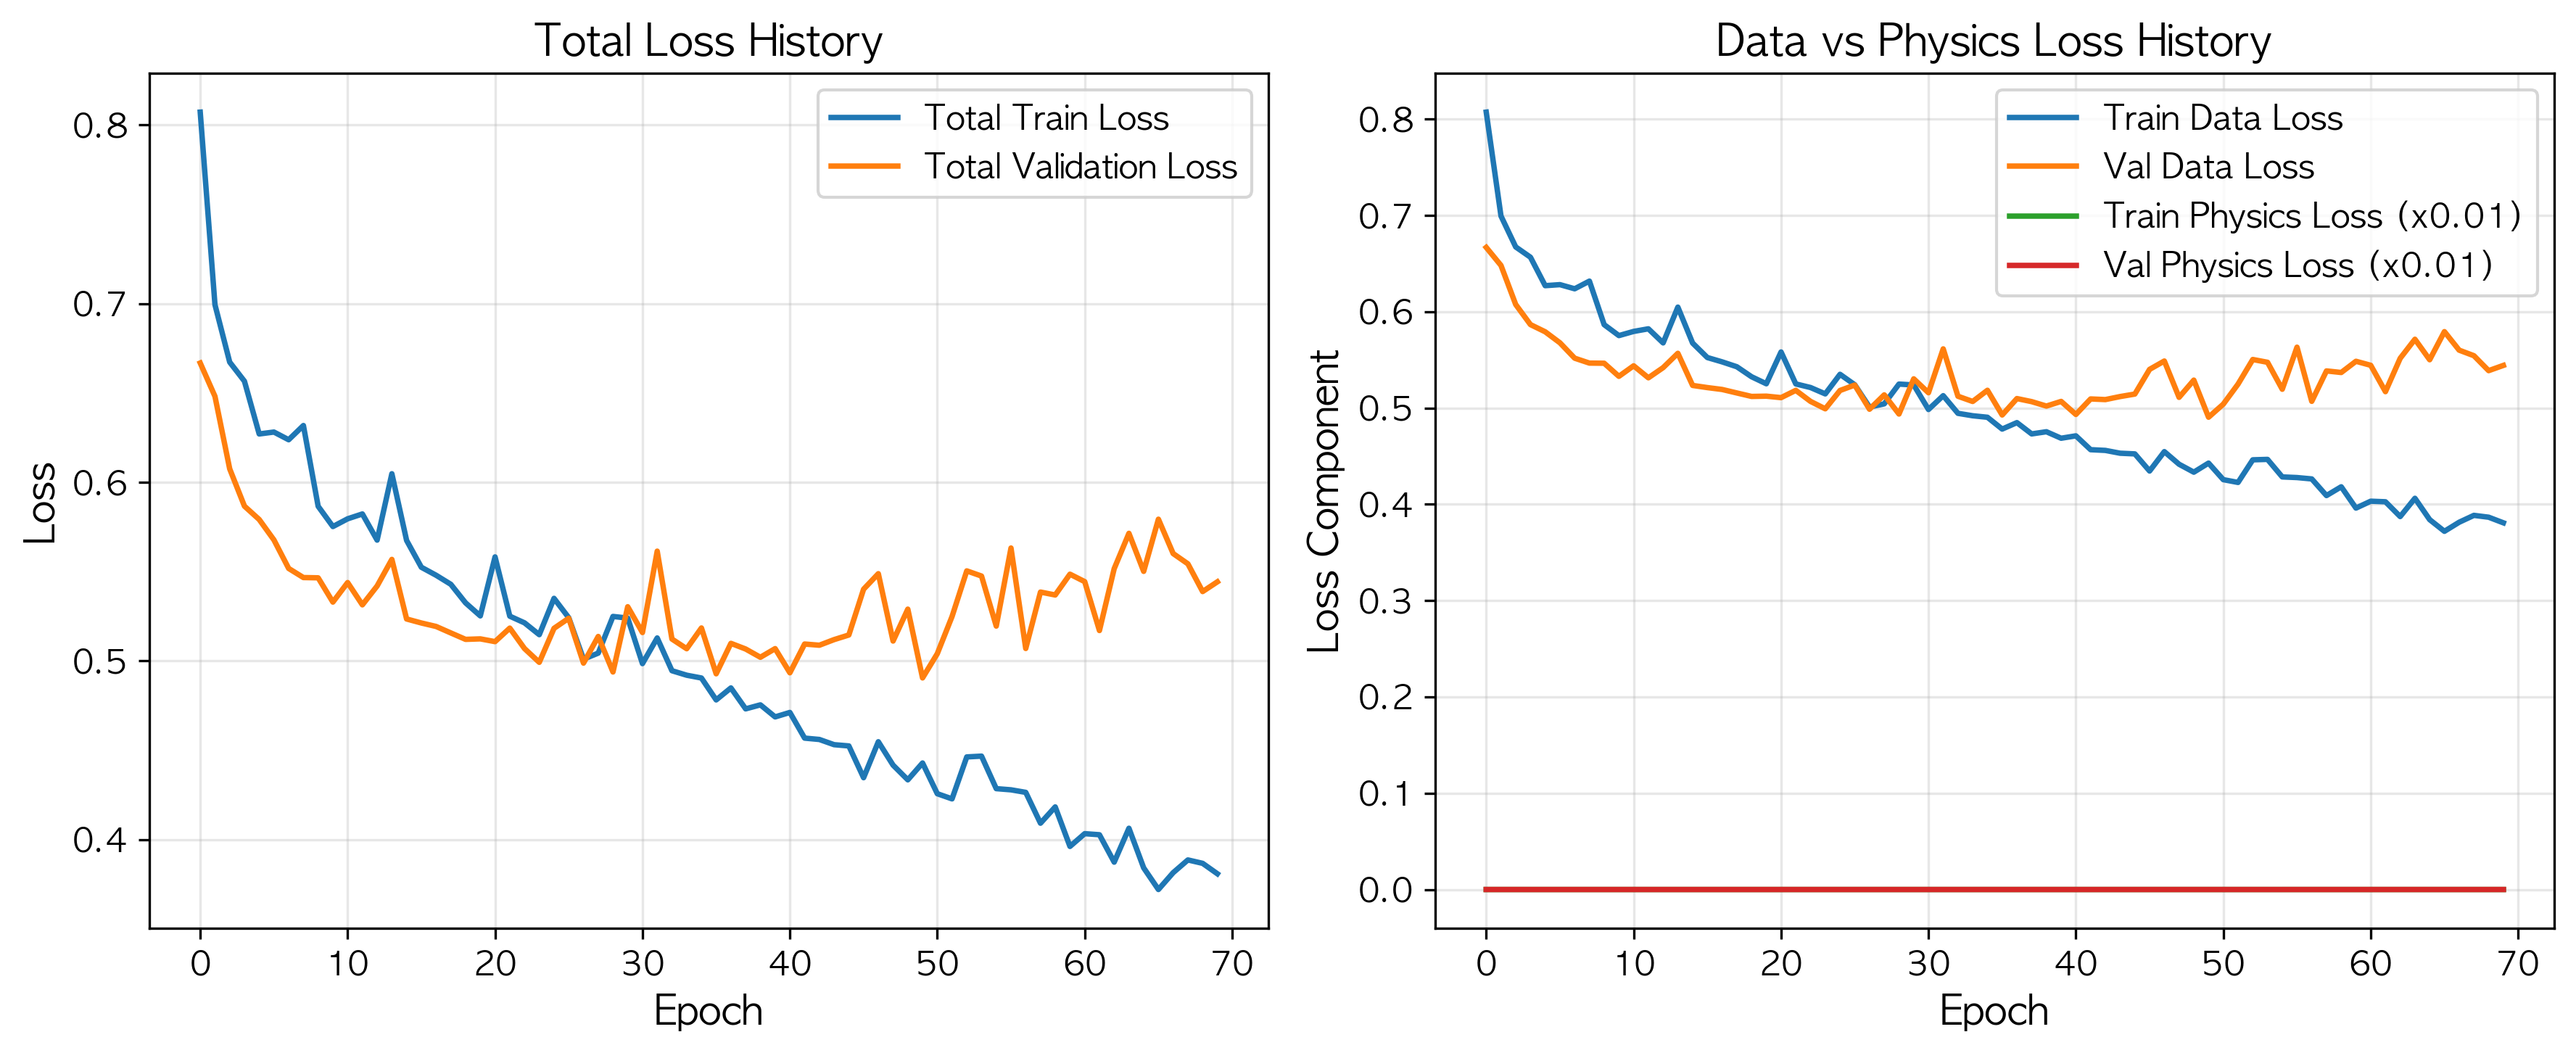

In [20]:
# Cell 9: 학습 루프 (Training Loop)

if len(df) > 0 and 'train_loader' in locals() and 'val_loader' in locals(): # 데이터 로더 존재 확인
    # Hyperparameters
    learning_rate = 0.001
    epochs = 200
    patience = 20

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping parameters
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Lists to store loss history
    train_loss_history = []
    val_loss_history = []
    train_data_loss_hist = []
    train_phys_loss_hist = []
    val_data_loss_hist = []
    val_phys_loss_hist = []

    print(f"\n--- Starting Training ---")
    print(f"Epochs: {epochs}, LR: {learning_rate}, Lambda_Physics: {lambda_physics_value}, Patience: {patience}")

    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0.0
        train_epoch_data_loss = 0.0
        train_epoch_phys_loss = 0.0

        for batch_X, batch_y_scaled, batch_E in train_loader:
            batch_X, batch_y_scaled, batch_E = batch_X.to(device), batch_y_scaled.to(device), batch_E.to(device)

            outputs_scaled = model(batch_X)
            loss, data_loss, phys_loss = pinn_loss_function(
                outputs_scaled, batch_y_scaled, batch_E, scaler_y, lambda_physics=lambda_physics_value, device=device
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
            train_epoch_data_loss += data_loss.item()
            # 물리 손실이 0이 아닐 때만 기록 (NaN 방지)
            train_epoch_phys_loss += phys_loss.item() if not torch.isnan(phys_loss) else 0.0


        avg_train_loss = train_epoch_loss / len(train_loader)
        avg_train_data_loss = train_epoch_data_loss / len(train_loader)
        avg_train_phys_loss = train_epoch_phys_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        train_data_loss_hist.append(avg_train_data_loss)
        train_phys_loss_hist.append(avg_train_phys_loss)

        # Validation phase
        model.eval()
        val_epoch_loss = 0.0
        val_epoch_data_loss = 0.0
        val_epoch_phys_loss = 0.0
        with torch.no_grad():
            for batch_X_val, batch_y_val_scaled, batch_E_val in val_loader:
                batch_X_val, batch_y_val_scaled, batch_E_val = batch_X_val.to(device), batch_y_val_scaled.to(device), batch_E_val.to(device)

                outputs_val_scaled = model(batch_X_val)
                val_loss, val_data_loss, val_phys_loss = pinn_loss_function(
                     outputs_val_scaled, batch_y_val_scaled, batch_E_val, scaler_y, lambda_physics=lambda_physics_value, device=device
                )
                val_epoch_loss += val_loss.item()
                val_epoch_data_loss += val_data_loss.item()
                val_epoch_phys_loss += val_phys_loss.item() if not torch.isnan(val_phys_loss) else 0.0


        avg_val_loss = val_epoch_loss / len(val_loader)
        avg_val_data_loss = val_epoch_data_loss / len(val_loader)
        avg_val_phys_loss = val_epoch_phys_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)
        val_data_loss_hist.append(avg_val_data_loss)
        val_phys_loss_hist.append(avg_val_phys_loss)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f} (Data: {avg_train_data_loss:.4f}, Phys: {avg_train_phys_loss:.4f}), "
              f"Val Loss: {avg_val_loss:.4f} (Data: {avg_val_data_loss:.4f}, Phys: {avg_val_phys_loss:.4f})")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_fatigue_pinn_model.pth')
            print(f"  Validation loss improved. Saved best model.")
        else:
            epochs_no_improve += 1
            print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            break

    print("\n--- Training Complete ---")

    # Plot loss history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Total Train Loss')
    plt.plot(val_loss_history, label='Total Validation Loss')
    plt.title('Total Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_data_loss_hist, label='Train Data Loss')
    plt.plot(val_data_loss_hist, label='Val Data Loss')
    # 물리 손실 시각화 시 lambda 곱해서 스케일 확인
    plt.plot(np.array(train_phys_loss_hist) * lambda_physics_value, label=f'Train Physics Loss (x{lambda_physics_value:.2f})')
    plt.plot(np.array(val_phys_loss_hist) * lambda_physics_value, label=f'Val Physics Loss (x{lambda_physics_value:.2f})')
    plt.title('Data vs Physics Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Component')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("\\nSkipping training loop as data is not available.")


--- 테스트 세트 평가 중 ---

테스트 세트 성능 (원래 스케일):
  spf_MPa:
    MSE: 101143.9062
    R2 Score: 0.7091
  b:
    MSE: 0.0006
    R2 Score: 0.2954
  epf:
    MSE: 1.9189
    R2 Score: 0.0829
  c:
    MSE: 0.0119
    R2 Score: 0.4295

예측값 vs. 실제값 그래프 생성 중...


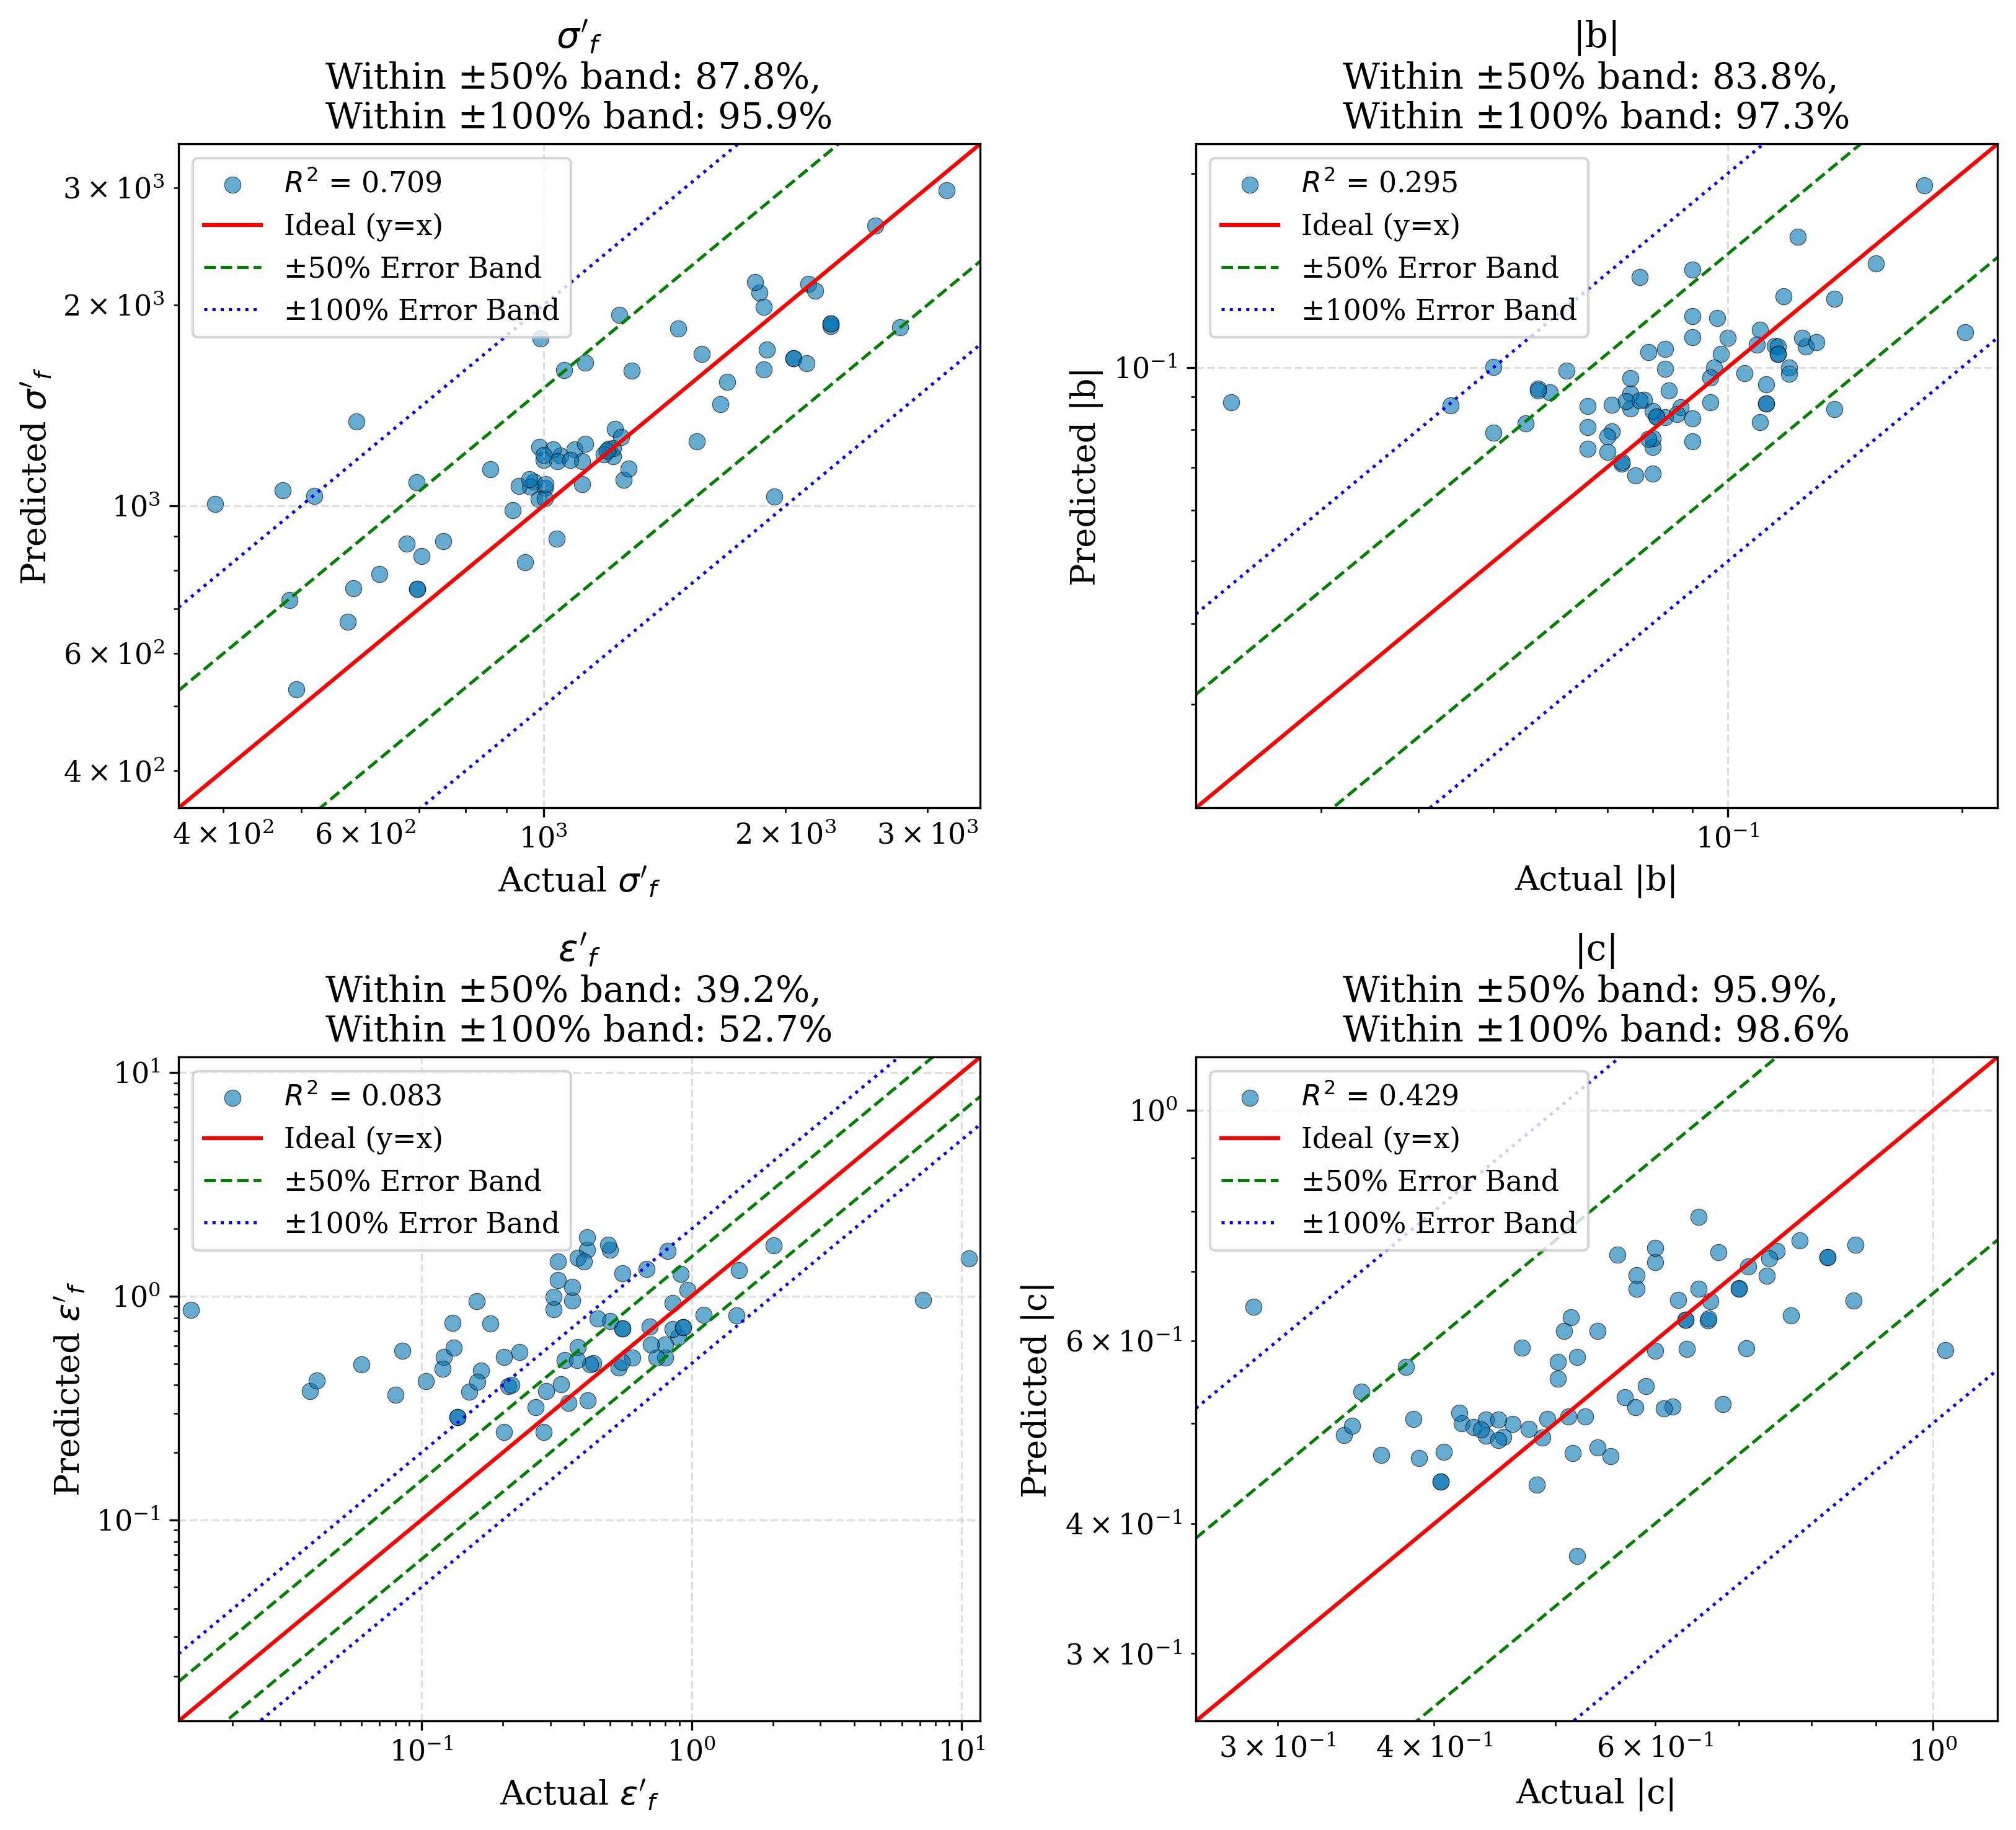

In [21]:
# Cell 10: Evaluation

# Load the best model saved during training
model.load_state_dict(torch.load('best_fatigue_pinn_model.pth', map_location=device))
model.eval() # Set to evaluation mode

all_preds_scaled = []
all_targets_scaled = []
all_targets_orig = []

print("\n--- 테스트 세트 평가 중 ---")
with torch.no_grad():
    for batch_X_test, batch_y_test_scaled, batch_E_test, batch_y_test_orig in test_loader:
        batch_X_test, batch_y_test_scaled = batch_X_test.to(device), batch_y_test_scaled.to(device)

        # Predict scaled parameters
        outputs_test_scaled = model(batch_X_test)

        all_preds_scaled.append(outputs_test_scaled.cpu().numpy())
        all_targets_scaled.append(batch_y_test_scaled.cpu().numpy())
        all_targets_orig.append(batch_y_test_orig.cpu().numpy())

# Concatenate results from all batches
all_preds_scaled = np.concatenate(all_preds_scaled, axis=0)
all_targets_scaled = np.concatenate(all_targets_scaled, axis=0)
all_targets_orig = np.concatenate(all_targets_orig, axis=0)

# Inverse transform predictions to original scale
all_preds_orig = scaler_y.inverse_transform(all_preds_scaled)

# Calculate metrics for each parameter in original scale
metrics = {}
print("\n테스트 세트 성능 (원래 스케일):")
for i, param_name in enumerate(target_cols):
    param_pred = all_preds_orig[:, i]
    param_true = all_targets_orig[:, i]

    mse = mean_squared_error(param_true, param_pred)
    r2 = r2_score(param_true, param_pred)
    metrics[param_name] = {'MSE': mse, 'R2': r2}
    print(f"  {param_name}:")
    print(f"    MSE: {mse:.4f}")
    print(f"    R2 Score: {r2:.4f}")

# Visualize Predictions vs. Actuals
print("\n예측값 vs. 실제값 그래프 생성 중...")

import matplotlib as mpl
# 폰트 및 전역 스타일 설정
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 1.8,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 300,  # 고해상도
})

# 색상 팔레트 선택 (Color Universal Design safe)
import seaborn as sns
palette = sns.color_palette("colorblind")  # or "muted", "Set2", "deep"

# 2x2 그리드로 변경
fig, axes = plt.subplots(2, 2, figsize=(11, 10))
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 쉽게 접근

for i, param_name in enumerate(target_cols):
    param_pred = all_preds_orig[:, i]
    param_true = all_targets_orig[:, i]
    
    # b와 c 파라미터에 대해 절대값 사용
    if param_name == 'b' or param_name == 'c':
        param_pred = np.abs(param_pred)
        param_true = np.abs(param_true)
    
    # 오차 허용 밴드 계산 (예측값이 실제값의 ±50% 또는 ±100% 범위 내에 있는지)
    ratio = param_pred / param_true
    inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100  # ±50% 오차 범위 내 비율
    inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100     # ±100% 오차 범위 내 비율

    min_val = min(param_pred.min(), param_true.min()) * 0.9
    max_val = max(param_pred.max(), param_true.max()) * 1.1
    
    # 0이나 음수 값이 있을 경우 로그 스케일에 적합한 최소값 설정
    if min_val <= 0:
        min_val = 1e-6  # 작은 양수값으로 설정
    
    line_vals = np.linspace(min_val, max_val, 100)

    # 산점도
    axes[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=palette[0], edgecolor='k', linewidth=0.3, label=f'$R^2$ = {metrics[param_name]["R2"]:.3f}')

    # 기준선 (y=x) 및 오차 허용 밴드
    axes[i].plot(line_vals, line_vals, 'r-', linewidth=1.5, label='Ideal (y=x)')
    
    # 1.5x error bands (±50% error)
    axes[i].plot(line_vals, line_vals * 1.5, 'g--', linewidth=1.2, label='±50% Error Band')
    axes[i].plot(line_vals, line_vals / 1.5, 'g--', linewidth=1.2)
    
    # 2x error bands (±100% error)
    axes[i].plot(line_vals, line_vals * 2.0, 'b:', linewidth=1.2, label='±100% Error Band')
    axes[i].plot(line_vals, line_vals * 0.5, 'b:', linewidth=1.2)

    # 로그 스케일 설정 (multiplicative factor가 additive offset으로 보임)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')

    # Labels and title
    if param_name == 'b' or param_name == 'c':
        axes[i].set_xlabel(f'Actual |{param_name}|')
        axes[i].set_ylabel(f'Predicted |{param_name}|')
        axes[i].set_title(f'|{param_name}|\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
    elif param_name == 'spf_MPa':
        axes[i].set_xlabel(f'Actual $\\sigma\'_f$')
        axes[i].set_ylabel(f'Predicted $\\sigma\'_f$')
        axes[i].set_title(f'$\\sigma\'_f$\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
    elif param_name == 'epf':
        axes[i].set_xlabel(f'Actual $\\varepsilon\'_f$')
        axes[i].set_ylabel(f'Predicted $\\varepsilon\'_f$')
        axes[i].set_title(f'$\\varepsilon\'_f$\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
    else:
        axes[i].set_xlabel(f'Actual {param_name}')
        axes[i].set_ylabel(f'Predicted {param_name}')
        axes[i].set_title(f'{param_name}\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
    
    axes[i].set_xlim(min_val, max_val)
    axes[i].set_ylim(min_val, max_val)
    axes[i].legend(frameon=True, loc='upper left')
    axes[i].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("FatifueParameters_prediction_actual.pdf", bbox_inches='tight')  # 논문용 PDF 저장
plt.show()


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 


--- Testing E-N and Gamma-N Curve Generation ---
Example Input:
  E: 190000 MPa
  YS: 212 MPa
  TS: 564 MPa
  HB: 128.0

인장 파라미터 예측 결과:
  spf_MPa: 1188.3882
  b: -0.1289
  epf: 0.5180
  c: -0.4681

전단 파라미터 예측 결과:
  tauf_MPa: 686.1162
  gammaf: 0.8971
  b0: -0.1289
  c0: -0.4681
  conversion_method: von Mises


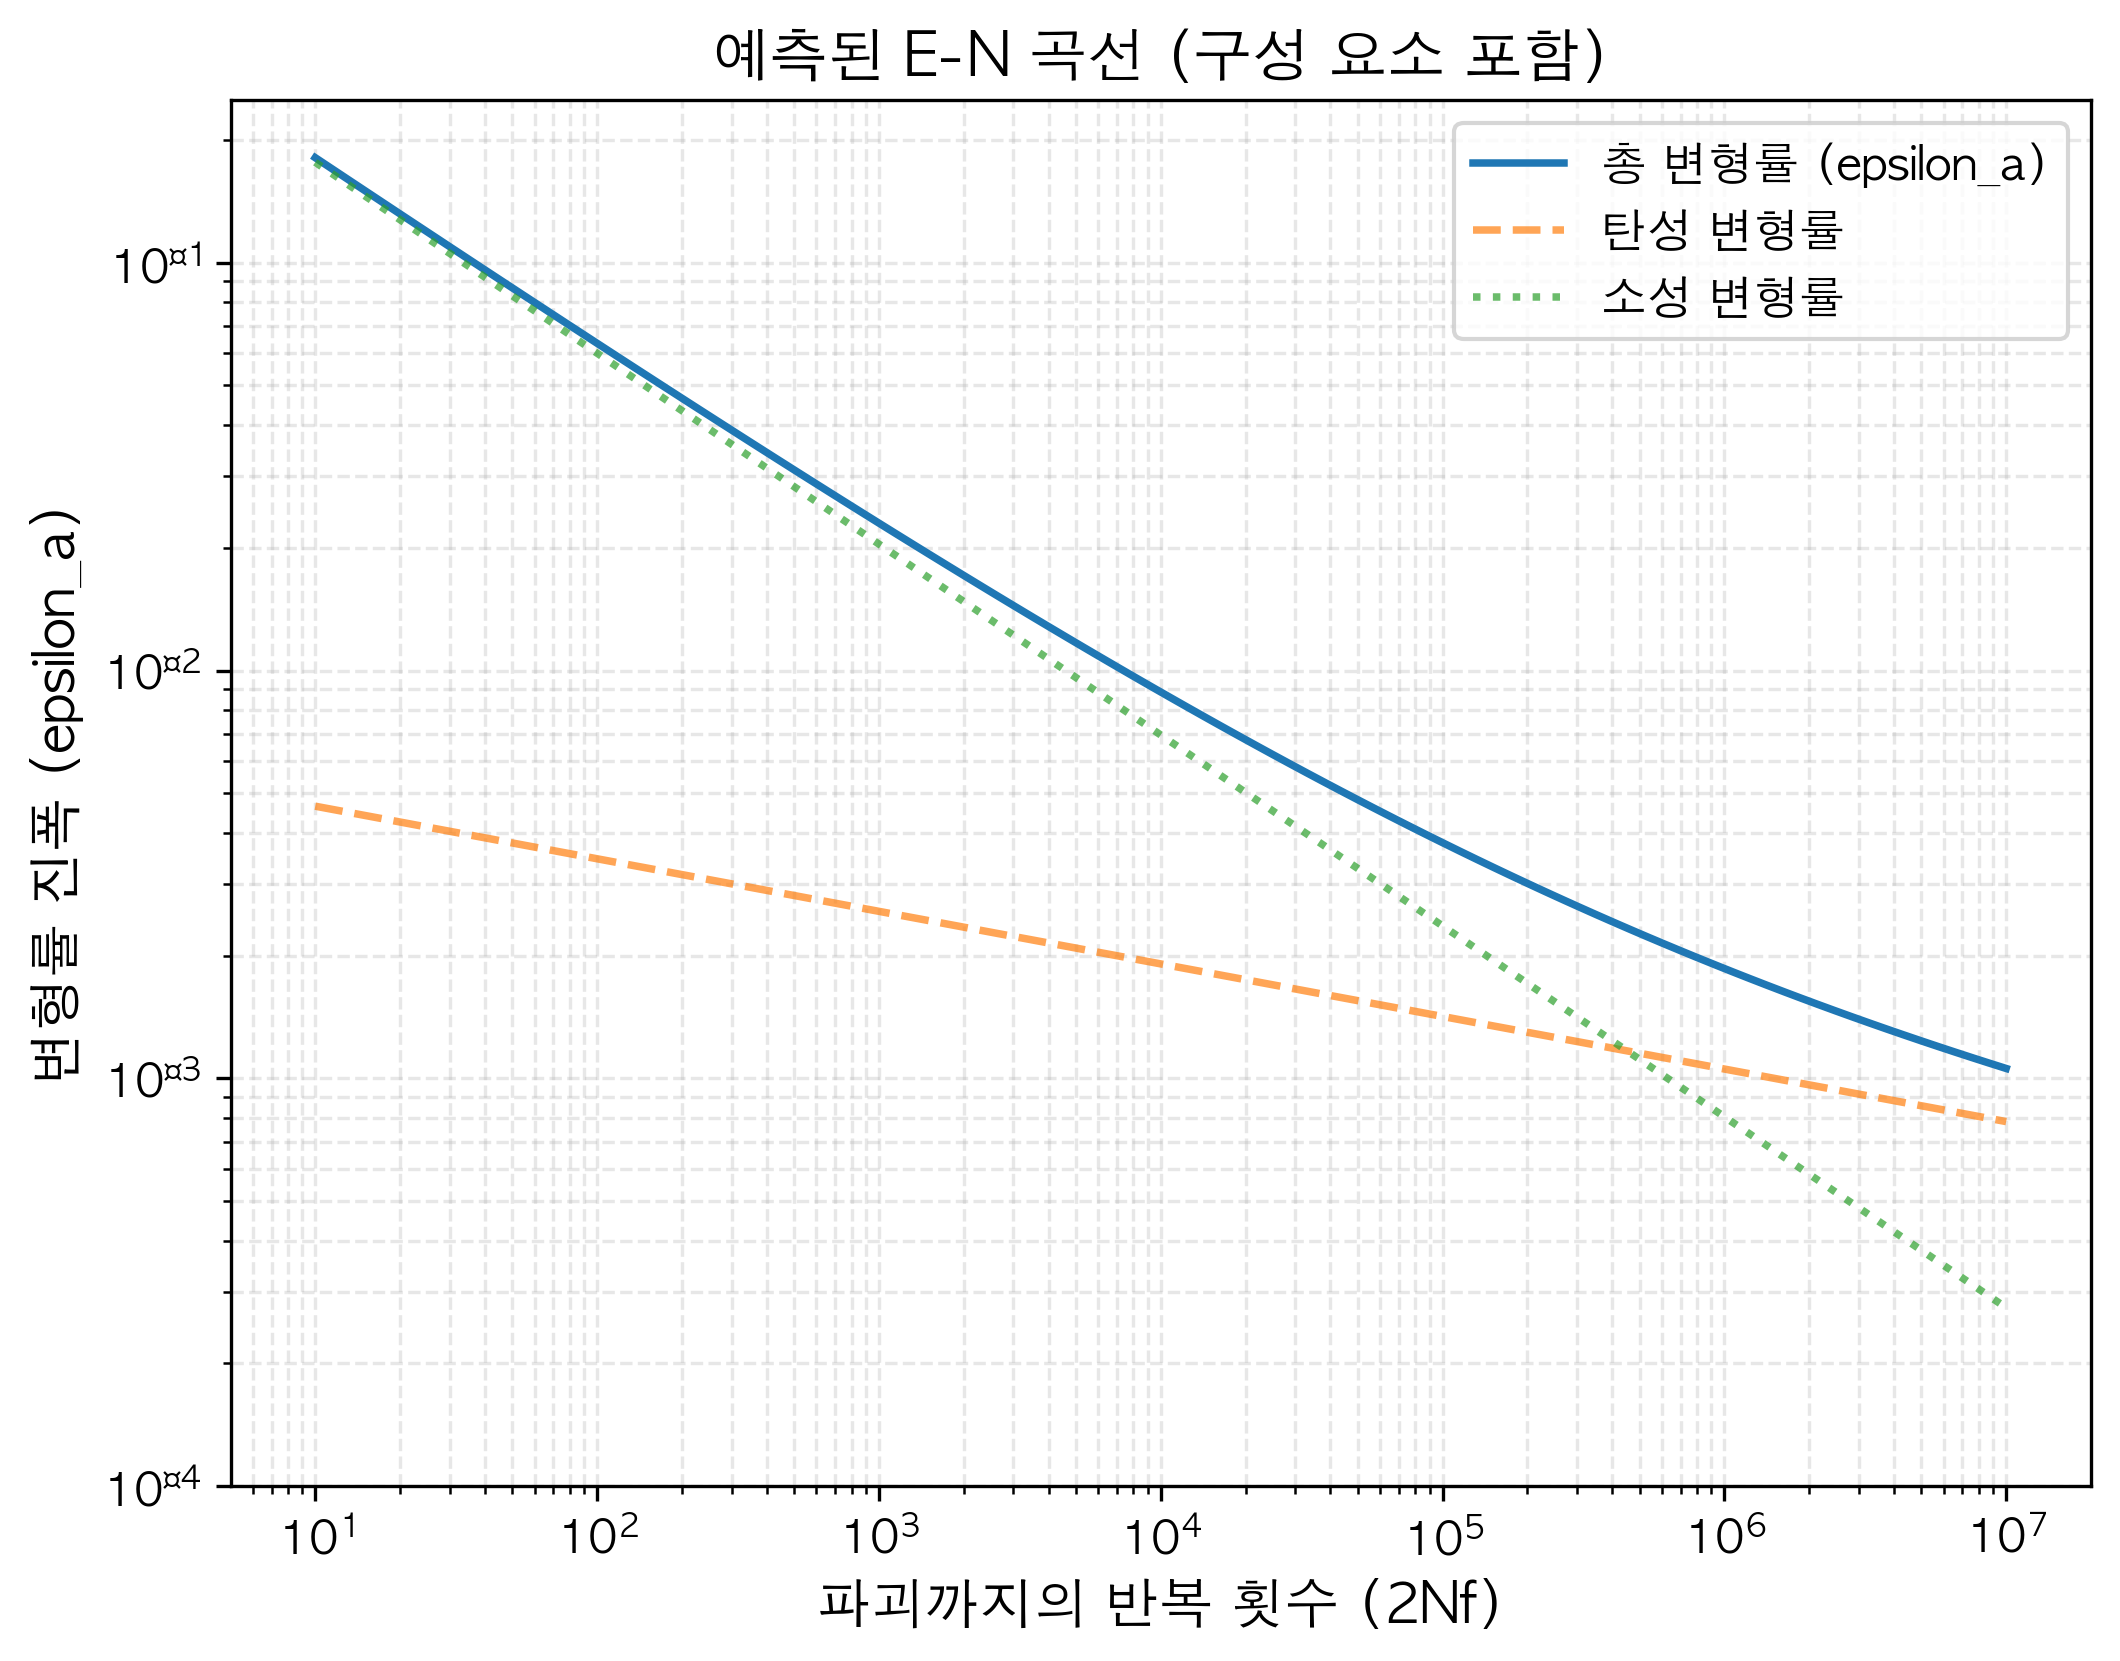

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

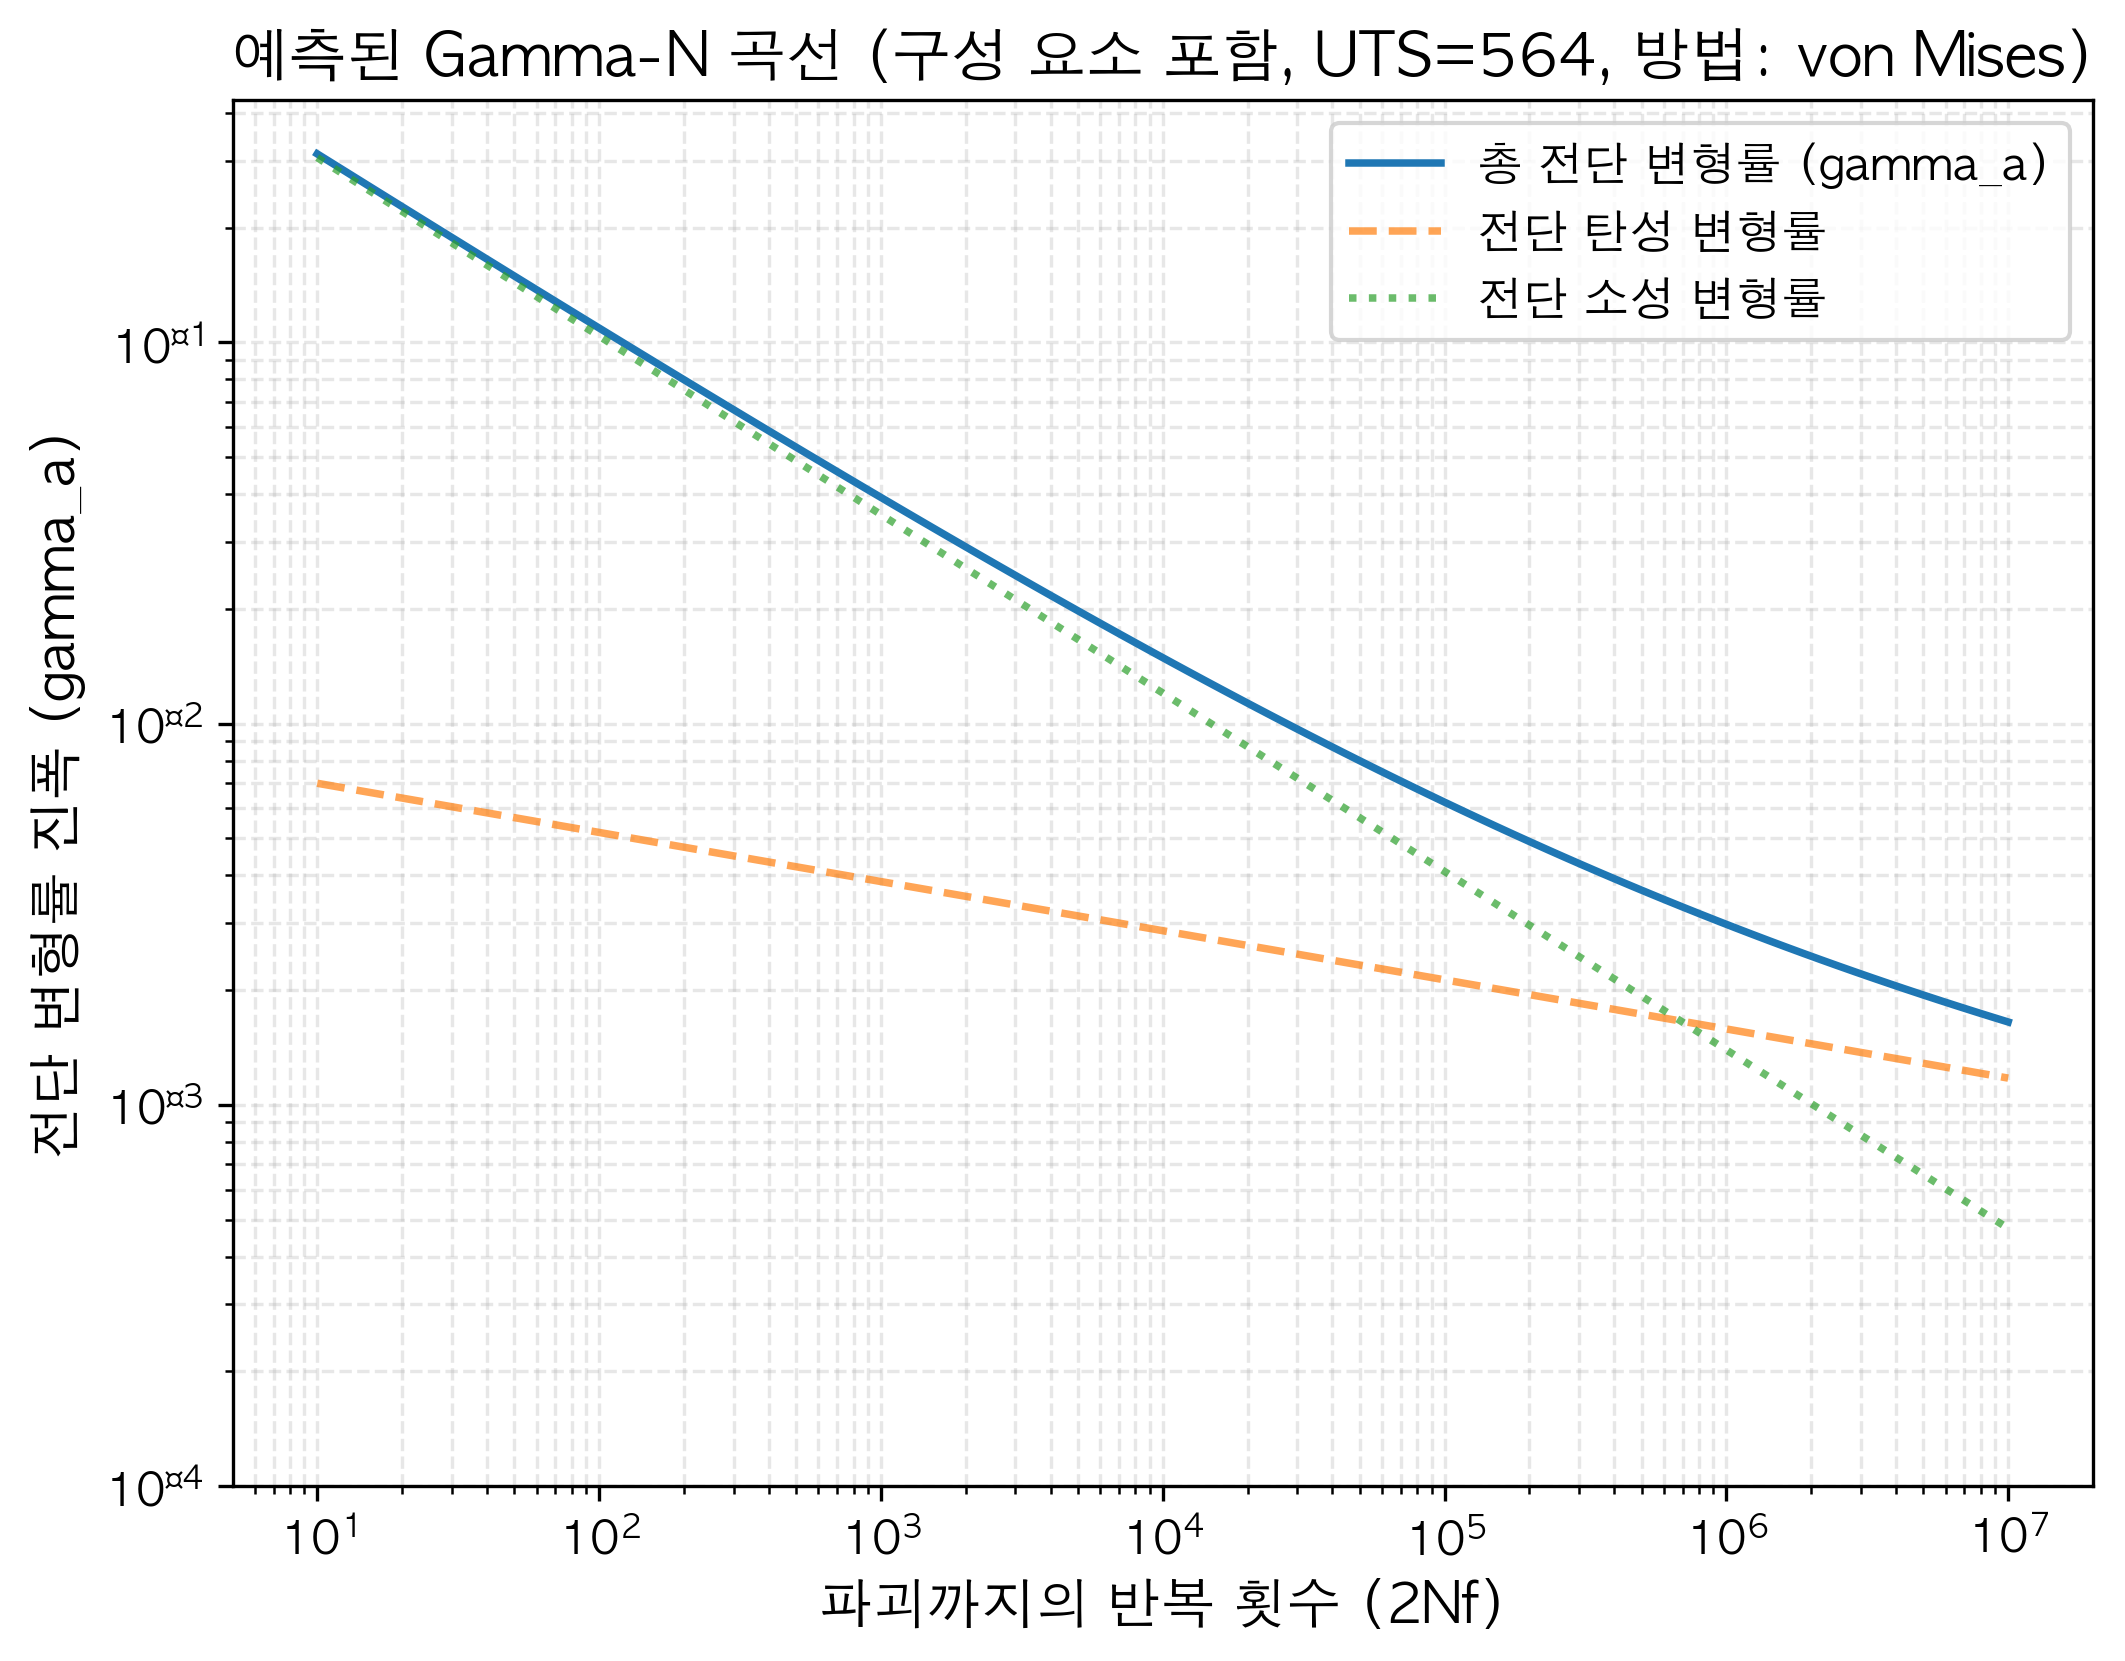

In [22]:
# Cell 11: E-N 및 Gamma-N 곡선 생성 함수 (수정됨)

if len(df) > 0:
    def predict_fatigue_curves(E_val, YS_val, TS_val, HB_val, model, scaler_X, scaler_y, device, nu=0.3):
        """
        Predicts fatigue parameters and generates E-N and Gamma-N curve data.

        Args:
            E_val (float): Elastic Modulus (MPa)
            YS_val (float): Yield Strength (MPa)
            TS_val (float): Ultimate Tensile Strength (MPa)
            HB_val (float): Brinell Hardness (processed value)
            model (torch.nn.Module): Trained FatiguePINN model.
            scaler_X (StandardScaler): Fitted scaler for input features.
            scaler_y (StandardScaler): Fitted scaler for tensile output parameters.
            device (str): Device ('cpu', 'cuda', 'mps')
            nu (float, optional): Poisson's ratio. Defaults to 0.3.

        Returns:
            tuple: (tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain,
                    shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain)
                   - tensile_params (dict): Predicted tensile parameters.
                   - reversals (np.array): Reversals to failure (2Nf).
                   - strain_amplitude_en (np.array): Total tensile strain amplitude (epsilon_a).
                   - elastic_strain (np.array): Elastic tensile strain amplitude.
                   - plastic_strain (np.array): Plastic tensile strain amplitude.
                   - shear_params (dict): Converted shear parameters (with conversion_method).
                   - strain_amplitude_gn (np.array): Total shear strain amplitude (gamma_a).
                   - elastic_shear_strain (np.array): Elastic shear strain amplitude.
                   - plastic_shear_strain (np.array): Plastic shear strain amplitude.
        """
        model.eval() # Ensure model is in eval mode

        # --- 1. 인장 파라미터 예측 ---
        input_features = np.array([[E_val, YS_val, TS_val, HB_val]])
        input_scaled = scaler_X.transform(input_features)
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

        with torch.no_grad():
            predicted_tensile_params_scaled = model(input_tensor)
        predicted_tensile_params_orig = scaler_y.inverse_transform(predicted_tensile_params_scaled.cpu().numpy())[0]

        tensile_target_cols_local = ['spf_MPa', 'b', 'epf', 'c'] # 여기서 다시 정의 (함수 범위)
        tensile_params = {name: val for name, val in zip(tensile_target_cols_local, predicted_tensile_params_orig)}
        spf_prime = tensile_params['spf_MPa']
        b = tensile_params['b']
        epf_prime = tensile_params['epf']
        c = tensile_params['c']

        reversals = np.logspace(1, 7, num=100) # 공통 사용

        # --- 2. 인장 E-N 곡선 계산 ---
        E_val_safe = max(E_val, 1e-6) # 0 방지
        elastic_strain = (spf_prime / E_val_safe) * (reversals ** b)
        plastic_strain = epf_prime * (reversals ** c)
        strain_amplitude_en = elastic_strain + plastic_strain

        # --- 3. 전단 파라미터 변환 ---
        shear_params = {}
        conversion_method = "Unknown"

        if TS_val <= 1100:
            # von Mises 기준
            tauf_prime = spf_prime / np.sqrt(3) if spf_prime is not None else None
            gammaf_prime = np.sqrt(3) * epf_prime if epf_prime is not None else None
            b0 = b
            c0 = c
            conversion_method = "von Mises"
        elif TS_val >= 1696:
            # Max Principal 기준 (임시: von Mises 사용)
            # TODO: Implement correct conversion for Max Principal Stress/Strain
            tauf_prime   = spf_prime   / (1 + 0.3)
            gammaf_prime = 2 * epf_prime
            b0 = b; c0 = c
            conversion_method = "Max Principal Strain"
            # print("Warning: Using von Mises as placeholder for Max Principal criterion.")
            # tauf_prime = spf_prime / np.sqrt(3) if spf_prime is not None else None
            # gammaf_prime = np.sqrt(3) * epf_prime if epf_prime is not None else None
            # b0 = b
            # c0 = c
            # conversion_method = "Max Principal (Placeholder: von Mises)" 
        else: # 1100 < UTS < 1696
            # 기본값: von Mises
            tauf_prime = spf_prime / np.sqrt(3) if spf_prime is not None else None
            gammaf_prime = np.sqrt(3) * epf_prime if epf_prime is not None else None
            b0 = b
            c0 = c
            conversion_method = "von Mises (Intermediate Default)"

        # 변환된 파라미터 저장 (None 처리 포함)
        shear_params['tauf_MPa'] = tauf_prime if tauf_prime is not None else np.nan
        shear_params['gammaf'] = gammaf_prime if gammaf_prime is not None else np.nan
        shear_params['b0'] = b0 if b0 is not None else np.nan
        shear_params['c0'] = c0 if c0 is not None else np.nan
        shear_params['conversion_method'] = conversion_method


        # --- 4. 전단 탄성 계수 G 계산 ---
        G_val = E_val_safe / (2 * (1 + nu))

        # --- 5. 전단 Gamma-N 곡선 계산 ---
        # 변환된 파라미터가 유효한 경우에만 계산
        if not any(np.isnan(val) for key, val in shear_params.items() if key != 'conversion_method'):
             elastic_shear_strain = (tauf_prime / G_val) * (reversals ** b0)
             plastic_shear_strain = gammaf_prime * (reversals ** c0)
             strain_amplitude_gn = elastic_shear_strain + plastic_shear_strain
        else:
             print("Warning: Could not calculate shear curve due to invalid converted parameters.")
             strain_amplitude_gn = np.full_like(reversals, np.nan) # NaN 배열 반환
             elastic_shear_strain = np.full_like(reversals, np.nan)
             plastic_shear_strain = np.full_like(reversals, np.nan)


        return tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain, shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain

    # --- 함수 테스트 ---
    print("\n--- Testing E-N and Gamma-N Curve Generation ---")
    try:
        # 테스트셋의 첫 번째 샘플 사용
        example_input_X = X_test[0] # 원본 스케일 특징
        example_E = E_test[0]       # 원본 스케일 E
        example_TS = example_input_X[2] # 원본 스케일 TS
        example_HB = example_input_X[-1]  # 처리된 HB (마지막 특징)

        print(f"Example Input:")
        print(f"  E: {example_E:.0f} MPa")
        print(f"  YS: {example_input_X[1]:.0f} MPa")
        print(f"  TS: {example_TS:.0f} MPa")
        print(f"  HB: {example_HB:.1f}")

        tensile_p, rev_en, strain_en, elastic_strain, plastic_strain, shear_p, rev_gn, strain_gn, elastic_shear_strain, plastic_shear_strain = predict_fatigue_curves(
            example_E, example_input_X[1], example_TS, example_HB,
            model, scaler_X, scaler_y, device, nu=0.3
        )

        print("\n인장 파라미터 예측 결과:")
        for name, val in tensile_p.items(): print(f"  {name}: {val:.4f}")

        print("\n전단 파라미터 예측 결과:")
        for name, val in shear_p.items(): print(f"  {name}: {val if isinstance(val, str) else f'{val:.4f}'}")

        # 한글 폰트 설정
        import matplotlib.font_manager as fm
        # 시스템에 설치된 폰트 목록 확인 (선택사항)
        # print([f.name for f in fm.fontManager.ttflist])
        
        # 한글 폰트 설정 (시스템에 설치된 한글 폰트 중 하나 선택)
        plt.rcParams['font.family'] = 'AppleGothic'  # macOS
        # plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
        # plt.rcParams['font.family'] = 'NanumGothic'  # 나눔고딕 설치된 경우
        plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

        # E-N 곡선 플롯 (구성 요소 포함)
        plt.figure(figsize=(8, 6))
        plt.loglog(rev_en, strain_en, '-', label='총 변형률 (epsilon_a)')
        plt.loglog(rev_en, elastic_strain, '--', label='탄성 변형률', alpha=0.7)
        plt.loglog(rev_en, plastic_strain, ':', label='소성 변형률', alpha=0.7)
        plt.xlabel('파괴까지의 반복 횟수 (2Nf)')
        plt.ylabel('변형률 진폭 (epsilon_a)')
        plt.title('예측된 E-N 곡선 (구성 요소 포함)')
        plt.legend()
        plt.grid(True, which="both", ls="--")
        plt.ylim(bottom=1e-4)
        plt.show()

        # Gamma-N 곡선 플롯 (구성 요소 포함)
        plt.figure(figsize=(8, 6))
        if not np.isnan(strain_gn).all(): # NaN이 아닌 경우에만 플롯
             plt.loglog(rev_gn, strain_gn, '-', label='총 전단 변형률 (gamma_a)')
             plt.loglog(rev_gn, elastic_shear_strain, '--', label='전단 탄성 변형률', alpha=0.7)
             plt.loglog(rev_gn, plastic_shear_strain, ':', label='전단 소성 변형률', alpha=0.7)
             plt.xlabel('파괴까지의 반복 횟수 (2Nf)')
             plt.ylabel('전단 변형률 진폭 (gamma_a)')
             plt.title(f'예측된 Gamma-N 곡선 (구성 요소 포함, UTS={example_TS:.0f}, 방법: {shear_p["conversion_method"]})')
             plt.legend()
             plt.grid(True, which="both", ls="--")
             plt.ylim(bottom=1e-4)
        else:
             plt.text(0.5, 0.5, '전단 곡선을 생성할 수 없습니다', ha='center', va='center')
             plt.title('예측된 Gamma-N 곡선 (계산 실패)')

        plt.show()

    except NameError:
         print("오류: 테스트 데이터(X_test, E_test) 또는 모델/스케일러를 사용할 수 없습니다. 이전 셀을 실행하세요.")
    except IndexError:
         print("오류: 테스트 데이터가 비어 있거나 형태가 올바르지 않습니다.")
    except Exception as e:
         print(f"테스트 중 오류가 발생했습니다: {e}")
else:
     print("\n곡선 생성 함수 정의 및 테스트를 건너뜁니다.")
